# Lab-03: Monte Carlo Methods

## References

- [Wikiversity, Reinforcement Learning/ Monte Carlo policy Evaluation](https://en.wikiversity.org/wiki/Reinforcement_Learning/Monte_Carlo_Policy_Evaluation#:~:text=of%20sample%20size.-,Incremental%20Monte%20Carlo,the%20system%20is%20non%2Dstationary.)
- [RL Book from Sutton & Barto, page.92](http://incompleteideas.net/book/RLbook2020.pdf)

In our previous lab, we learned about Makov Decision Process(MDP) and Dynamic programing(DP). Generally, MDP and DP require the model of environment and it's dynamics to be fully known or predictable(which we called it Finite MDP). In MDP, at each time step, the process is in some state $s$, the agent takes an action $a$ that is available in state $s$, the process moves to a new state $s'$ given by the state transitional probabilities or dynamics, and returns a reward $R_{a}(s, s')$. Thus, the next state $s'$ depends on the current state $s$ and the agent's action $a$. But given $s$ and $a$, it is conditionally independent of all previous states and actions; in other words, state transitions of an MDP satisfy the [Markov property](https://en.wikipedia.org/wiki/Markov_property).  

In reinforcement learning, such algorithms are called model-based reinforcement learning. There are a few challenges in model-based RL, such as the difficulty of accurately modeling complex environments and computation cost of planning, especially in high-dimensional spaces.

In this lab, we will work on another algorithm which does not require a prior knowledge of the environment, and it is a more scalable environment than DP. This is called model-free reinforcement learning or model-free approach. We will be working on one of the well known model-free algorithms, called Monte Carlo Methods(MC).

MC can predict state-values and state-action-values in a first-visit and every-visit manner. The process is used for exploration and exploitation. MC can be implemented with on-policy and off-policy to find optimal policy.

Monte Carlo methods do not require knowledge of the environment's transition probabilities and rewards (i.e., the model), making them model-free. They are particularly useful in environments where the model is unknown or difficult to model accurately. However, because they rely on complete episodes, they are not suitable for all problems, especially those involving continuing tasks without a natural endpoint.

## Monte Carlo Methods or Experiments

Monte Carlo methods, or Monte Carlo experiments, are a broad class of computational algorithms that rely on repeated random sampling to obtain numerical results. The underlying concept is to use randomness to solve problems that might be deterministic in principle.  
Examples can be seen in [Monte Carlo simulation](https://www.youtube.com/watch?v=7ESK5SaP-bc) and [Monte Carlo Method](https://en.wikipedia.org/wiki/Monte_Carlo_method#/media/File:Pi_monte_carlo_all.gif).  

$$ A_{square} = a^2 $$
$$ A_{circle} = \pi a^2 $$

Hence,
$$ \frac{A_{circle}}{A_{square}} = \frac{\pi a^2}{a^2} = \pi $$

<img src="img/montecarlo_simulation.png" title="Monte Carlo Simulation" style="width: 600px;" />  

**or**

$$ A_{square} = (2a)^2 = 4a^2 $$
$$ A_{circle} = \pi a^2 $$

Hence,
$$ \frac{A_{circle}}{A_{square}} = \frac{\pi a^2}{4a^2} = \frac{\pi}{4} $$   

<img src="img/montecarlo_simulation2.png" title="Monte Carlo Simulation 2" style="width: 400px;" />  

Let's try to code:

In [1]:
import torch
import numpy
import math
import matplotlib.pyplot as plt

In [2]:
n_point = 2000
points = torch.rand((n_point, 2)) * 2 - 1
print(points)

tensor([[ 0.3696, -0.2957],
        [ 0.6458, -0.8963],
        [-0.3291, -0.4168],
        ...,
        [-0.5541,  0.8541],
        [-0.6914, -0.6730],
        [ 0.2893, -0.2835]])


Find the points which are inside the circle, and keep them (this is for plot in the graph only)

In [3]:
points_circle_x = []
points_circle_y = []
n_point_circle = 0

pi_iteration = []
i = 1
for point in points:
    r = torch.sqrt(point[0] ** 2 + point[1] ** 2)
    if r <= 1:
        points_circle_x.append(point[0])
        points_circle_y.append(point[1])
        n_point_circle += 1
    pi_iteration.append(4 * (n_point_circle / i))
    i += 1
        
points_circle_x = numpy.asarray(points_circle_x)
points_circle_y = numpy.asarray(points_circle_y)

Find the estimate $\pi$

In [4]:
pi_estimated = 4 * n_point_circle / n_point
print('Estimated value of pi is:', pi_estimated)

Estimated value of pi is: 3.14


Plot to show the points and circle

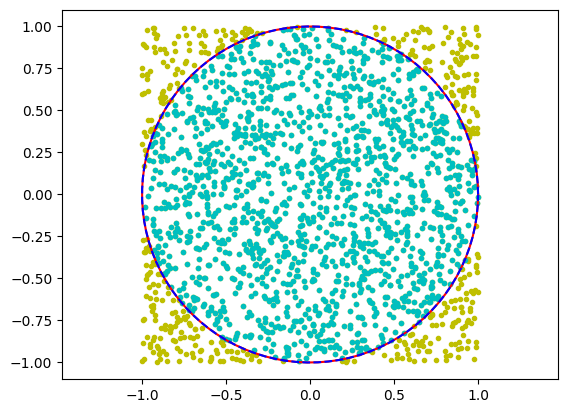

In [5]:
plt.plot(points[:, 0].numpy(), points[:, 1].numpy(), 'y.')
plt.plot(points_circle_x, points_circle_y, 'c.')
# plot real circle
i = torch.linspace(0, 2 * math.pi, 100)
plt.plot(torch.cos(i).numpy(), torch.sin(i).numpy(), 'r-')
# plot circle from estimate pi
i = torch.linspace(0, 2 * pi_estimated, 100)
plt.plot(torch.cos(i).numpy(), torch.sin(i).numpy(), 'b--')
plt.axis('equal')
plt.show()

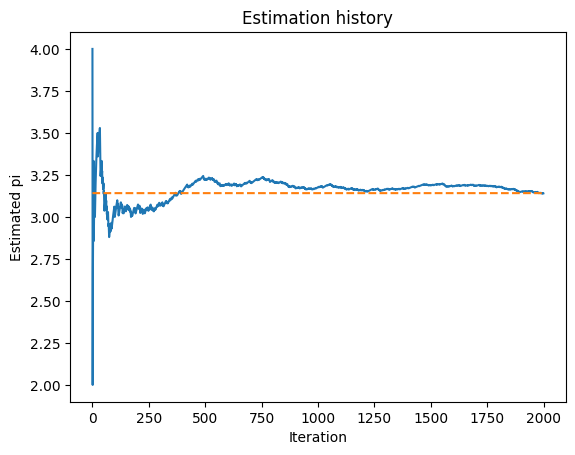

In [6]:
plt.plot(pi_iteration)
plt.plot([math.pi] * n_point, '--')
plt.xlabel('Iteration')
plt.ylabel('Estimated pi')
plt.title('Estimation history')
plt.show()

### Monte Carlo Policy Evaluation

In the last lab session, we applied **DP** algorithm into policy evaluation and the requirement for the algorithm are the followings:

- Full state-value transition matrix
- Reward matrix

Those are fully known environment. However, in the real-life situation, we have less information about the environment and we only observe the state partially. It turns out that the **model-based algorithms** are less effective due to poor estimate of the model environment and it's transitional probabilities. To address this issue, we can replace with **model-free algorithm** in which we don't explicitly require a prior knowledge for both transition and reward functions.

Recall from the previous labs, the cumulative future return(G) of a **Given Policy** from a process, which is the sum of the rewards over the long run, 

$$G_t=\sum_k \gamma^k R_{t+k+1}$$

MC policy evaluation uses **empirical mean return** instead of **expected return (as in DP)** to estimate the value function. There are two ways to perform MC policy evaluation.
- First-visit MC prediction -- averages the returns only for the first occurrence of a state, s, in an episode. 
- Every-visit MC prediction -- averages the returns for every occurrence of a state, s, in an episode.

First-visit MC prediction has fewer calculations than the every-visit version, so it is more frequently used.

### Incremental means

To update the MC method, the incremental means have been used to update the policy. An incremental or running mean allows us to keep an average for a list of numbers without having to remember the list. We hold one value that we incrementally update using the following general equation:

$$V(S_t) = V(S_t) + \alpha(G_t - V(S_t))$$

When $V(S_t)$ is the current state value for the policy, $\alpha$ is a discount rate, and $G_t$ is the cumulative future return at time $t$. If we set $\alpha = 1/N(s)$, we arrive at the original first-visit or every-visit MC algorithms, but if set $\alpha > 1/N(s)$, we have an algorithm that gives more weight to the newer data and is more suitable for non-stationary domains.

## FrozenLake and First-visit MC Policy Evaluation

Let's start in FrozenLake-v1 environment using first-visit MC prediction.

In [7]:
import gymnasium as gym
import torch


env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True, render_mode="ansi_list")

n_state = env.observation_space
print('State matrix:', n_state, 'number of state', n_state)

n_action = env.action_space
print('number of action:', n_action)

State matrix: Discrete(16) number of state Discrete(16)
number of action: Discrete(4)


In [8]:
def run_episode(env, policy):
    state, info = env.reset()
    # this is the difference between MC and DP, find rewards and states
    rewards = []
    states = [state]
    is_done = False
    truncated = False
    while not (is_done or truncated):
        action = int(policy[state].item())
        state, reward, is_done, truncated, info = env.step(action)
        # keep all states and reward
        states.append(state)
        rewards.append(reward)
    env.close()
    # convert to torch
    states = torch.tensor(states)
    rewards = torch.tensor(rewards)

    return states, rewards

Create MC prediction in first-visit.

In [9]:
def mc_prediction_first_visit(env, policy, gamma, n_episode):
    n_state = policy.shape[0]
    V = torch.zeros(n_state)
    N = torch.zeros(n_state)
    for episode in range(n_episode):
        # run 1 episode until end of the episode
        states_t, rewards_t = run_episode(env, policy)
        # print(states_t, rewards_t)
        return_t = 0
        first_visit = torch.zeros(n_state)
        G = torch.zeros(n_state)
        # take a look at the state and the reward from the last to first start
        # calculate given policy
        for state_t, reward_t in zip(reversed(states_t)[1:], reversed(rewards_t)):
            # calculate rewards
            # because the reward at the last can be only 0 or 1, otherwise are 0
            # so the reward at first start will be smallest
            return_t = gamma * return_t + reward_t
            # put the reward for the state into given policy
            # as you can see, if we come in the same state, it will be replaced to the early time when visit
            # That's why we call first-visit
            G[state_t] = return_t
            first_visit[state_t] = 1
        # at the end of given policy calculation
        # we need to update the state transition by summation them (prepare to average)
        for state in range(n_state):
            if first_visit[state] > 0:
                V[state] += G[state]
                N[state] += 1
    # average state transition here
    for state in range(n_state):
        if N[state] > 0:
            V[state] = V[state] / N[state]
    return V

Setup discount rate $\gamma$ as 1 and simulate 10,000 episodes

We tried to used <code>optimal_policy</code> from lab 02 (don't be worry, we just bring the data), and pass it into the first-visit MC function to evaluate, and see the results.

In [10]:
gamma = 1
n_episode = 10000

optimal_policy = torch.tensor([0., 3., 0., 3., 0., 0., 0., 0., 3., 1., 0., 0., 0., 2., 1., 0.])
value = mc_prediction_first_visit(env, optimal_policy, gamma, n_episode)
print('The value function calculated by first-visit MC prediction:\n', value)

The value function calculated by first-visit MC prediction:
 tensor([0.7337, 0.4891, 0.4210, 0.0000, 0.7337, 0.0000, 0.3571, 0.0000, 0.7337,
        0.7353, 0.6607, 0.0000, 0.0000, 0.8050, 0.8938, 0.0000])


As you can see, in MC-based prediction, it is not necessary to know about the full model of the environment. In most real-world cases, the transition matrix and reward matrix are not known beforehand, or are extremely difficult to obtain. Imagine how many possible states there are playing *chess* or *Go* and the number of possible actions; it is almost impossible to work out the transition matrix and reward matrix. Model-free reinforcement learning is about learning from experience by interacting with the environment.

We only considered what could be observed, which included the new state and reward in each step, and made predictions using the Monte Carlo method.

Note that the more episodes we simulate, the more accurate predictions we can obtain. If you plot the value updated after each episode, you will see how it converges over time, which is similar to what we saw when estimating the value of $\pi$.

### How about every-visit MC?

Take a look at every-visit MC function

In [11]:
def mc_prediction_every_visit(env, policy, gamma, n_episode):
    n_state = policy.shape[0]
    V = torch.zeros(n_state)
    N = torch.zeros(n_state)
    G = torch.zeros(n_state)
    for episode in range(n_episode):
        states_t, rewards_t = run_episode(env, policy)
        return_t = 0
        for state_t, reward_t in zip(reversed(states_t)[1:], reversed(rewards_t)):
            return_t = gamma * return_t + reward_t
            # Here is the difference, instead of discard the other visit
            # we calculate all visiting in the target state
            # That's why call every-visit
            G[state_t] += return_t
            N[state_t] += 1
    for state in range(n_state):
        if N[state] > 0:
            V[state] = G[state] / N[state]
    return V

In [12]:
e_value = mc_prediction_every_visit(env, optimal_policy, gamma, n_episode)
print('The value function calculated by every-visit MC prediction:\n', e_value)

The value function calculated by every-visit MC prediction:
 tensor([0.6416, 0.4693, 0.4083, 0.0000, 0.6421, 0.0000, 0.3540, 0.0000, 0.6580,
        0.6874, 0.6422, 0.0000, 0.0000, 0.7737, 0.8800, 0.0000])


Actually, the every-visit is more accurate than the first-visit, but it takes a lot of calculation, so it is not popular.

## Developing MC Control with Epsilon-Greedy Policy

We are now ready to consider how Monte Carlo estimation can be used in control, that is, to approximate optimal policies. According to the idea of generalized policy iteration(GPI), maintaining both an approximate policy and
an approximate value function.  

<img src="img/policy_evaluation_improvement.png" title="Evaluation and Improvement Loop" style="width: 200px;" />  

#### Greedy Policy
Policy improvement is done by making the policy greedy with respect to the current value function. In this case we have an action-value function, and therefore no model is needed to construct the greedy policy. For any action-value function q, the corresponding greedy policy is the one that, for each $s \in S$, deterministically chooses an action with maximal action-value.  

$$\pi(s) \, \dot{=} \, argmax_{a} \, q(s, a)$$

The downside of the greedy policy is that it always follows the policy that gives the highest value and never explore new policies. The greedy policy takes the action that looks best in the short term—after one step of lookahead—according to $\textit{v}_{\pi}$.

#### Epsilon Greedy Policy
In MC control with epsilon-greedy policy, we no longer exploit the best action all the time, but choose an action randomly under certain probabilities. Each of the non-greedy policies will be given a probability of:

$$\pi(s,a) = \frac{\epsilon}{|A|}$$

where:  
$|A|$ is the number of possible actions

The greedy action is given with the remaining portion of the probability as follows:

$$\pi(s,a) = 1 - \epsilon + \frac{\epsilon}{|A|}$$

Epsilon-greedy policy exploits the best action most of the time and also keeps exploring different actions from time to time.

## Modify MC control with epsilon-greedy policy with FrozenLake

From the code above, let's modify as below:

In [ ]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True, render_mode="ansi_list")

n_state = env.observation_space
print('State matrix:', n_state, 'number of state', n_state)

n_action = env.action_space
print('number of action:', n_action)

Modify run_episode to return states, actions, rewards

In [ ]:
def run_episode(env, Q, epsilon, n_action):
    """
    Run a episode and performs epsilon-greedy policy
    @param env: OpenAI Gym environment
    @param Q: Q-function
    @param epsilon: the trade-off between exploration and exploitation
    @param n_action: action space
    @return: resulting states, actions and rewards for the entire episode
    """
    state, info = env.reset()
    rewards = []
    actions = []
    states = []
    is_done = False
    truncated = False
    while not (is_done or truncated):
        probs = torch.ones(n_action) * epsilon / n_action
        best_action = torch.argmax(Q[state]).item()
        probs[best_action] += 1.0 - epsilon
        action = torch.multinomial(probs, 1).item()
        actions.append(action)
        states.append(state)
        state, reward, is_done, truncated, info = env.step(action)
        rewards.append(reward)
    return states, actions, rewards

Create MC_control using epsilon greedy

<img src="img/epsilon_greedy.png" title="Epsilon Soft Policies" style="width: 600px;" />  


In [ ]:
from collections import defaultdict

def mc_control_epsilon_greedy(env, gamma, n_episode, epsilon):
    """
    Obtain the optimal policy with on-policy MC control with epsilon_greedy
    @param env: OpenAI Gym environment
    @param gamma: discount factor
    @param n_episode: number of episodes
    @param epsilon: the trade-off between exploration and exploitation
    @return: the optimal Q-function, and the optimal policy
    """
    n_action = env.action_space.n
    G_sum = defaultdict(float)
    N = defaultdict(int)
    Q = defaultdict(lambda: torch.empty(n_action))
    for episode in range(n_episode):
        if (episode + 1) % 1000 == 0:
            print("Training episode {}".format(episode+1))
        states_t, actions_t, rewards_t = run_episode(env, Q, epsilon, n_action)
        return_t = 0
        G = {}
        for state_t, action_t, reward_t in zip(states_t[::-1], actions_t[::-1], rewards_t[::-1]):
            return_t = gamma * return_t + reward_t
            G[(state_t, action_t)] = return_t
        for state_action, return_t in G.items():
            state, action = state_action

            G_sum[state_action] += return_t
            N[state_action] += 1
            Q[state][action] = G_sum[state_action] / N[state_action]
    policy = {}
    for state, actions in Q.items():
        policy[state] = torch.argmax(actions).item()
    return Q, policy

Find optimal policy

In [ ]:
gamma = 1

n_episode = 100000
epsilon = 0.1

optimal_Q, optimal_policy = mc_control_epsilon_greedy(env, gamma, n_episode, epsilon)

To test the optimal policy, we need to run simulation using policy.

Let's create simulate_episode function:

In [ ]:
def simulate_episode(env, policy):
    state, info = env.reset()
    is_done = False
    truncated = False
    while not (is_done or truncated):
        action = policy[state]
        state, reward, is_done, truncated, info = env.step(action)
        return reward

In [ ]:
n_episode = 50000
n_win_optimal = 0
n_lose_optimal = 0

for episode in range(n_episode):
    if (episode + 1) % 1000 == 0:
        print("Testing episode {}".format(episode+1))
    reward = simulate_episode(env, optimal_policy)
    if reward == 1:
        n_win_optimal += 1
    elif reward == -1:
        n_lose_optimal += 1

In [ ]:
print('Winning probability under the optimal policy: {}'.format(n_win_optimal/n_episode))

print('Losing probability under the optimal policy: {}'.format(n_lose_optimal/n_episode))

## Lab Exercise:

1. Implement the Monte Carlo control with epsilon-greedy policy for LunarLander environment.
    - Replicate the below code and modifications for **LunarLander**.
    - Apply similar approach to Carpole environment.
    - Make videos that simulate both games.
    - Explain the results whether the agent learns well or not using this technique.
2. Implement the Monte Carlo control with epsilon-greedy policy for Blackjack environment.
    - What is the winning rate of your optimal policy?

In [ ]:
env = gym.make("LunarLander-v2", render_mode="rgp_array_list") ### Change the render_mode = "human" for rendering the video
state, info = env.reset()

print(state)

Since the state/observation space in **LunarLander** is in continuous values, we have to convert them to discrete integer values in order to update the Q-table. Below code execute the conversion of state space from floating point array into integer tuple.

Hint: You might need to put this line of code into your run_episode funcation for both games.

In [ ]:
state = tuple((state * 10).astype(int))
print(state)